In [1]:
import cv2
import numpy as np
from sklearn.utils import shuffle
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from utils.utils import load_dataset, download_dataset, create_cnn_model, get_callbacks, get_preds, show_train_loss_accuracy, show_metrics, INPUT_SHAPE, OUTPUT_CLASSES
%matplotlib inline
warnings.filterwarnings('ignore')

2025-10-02 23:28:48.327534: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-02 23:28:48.828866: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cenzi/Área de trabalho/Aulas/tcc/venv/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/cenzi/Área de trabalho/Aulas/tcc/venv/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exa

In [2]:
DATA_PATH = "./data_reclassified"
TEST_PATH = "./data_reclassified"
TRAIN_PATH = os.path.join(DATA_PATH, "train")
TEST_PATH = os.path.join(TEST_PATH, "test")

In [3]:
X_train, y_train, LABEL_MAP = load_dataset(TRAIN_PATH)
X_test, y_test, _ = load_dataset(TEST_PATH)

X_train.shape, y_train.shape, LABEL_MAP

((28709, 48, 48, 3),
 (28709,),
 {'angry': 0,
  'disgust': 1,
  'fear': 2,
  'happy': 3,
  'neutral': 4,
  'sad': 5,
  'surprise': 6})

In [4]:
# Resize images from 48x48 to 144x144
import cv2

X_train = np.array([cv2.resize(img, (144, 144)) for img in X_train])
X_test = np.array([cv2.resize(img, (144, 144)) for img in X_test])
X_train.shape, X_test.shape


((28709, 144, 144, 3), (7178, 144, 144, 3))

In [5]:
from tensorflow.keras.applications import VGG19, DenseNet201, ResNet50V2

OUTPUT_CLASSES = 7
INPUT_SHAPE = (144, 144, 3)


resnet50v2 = create_cnn_model(
    ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling=None,
    classes=OUTPUT_CLASSES,
    classifier_activation="softmax"
), OUTPUT_CLASSES, flatten=True)

denseNet201 = create_cnn_model(DenseNet201(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling=None,
    classes=OUTPUT_CLASSES,
    classifier_activation="softmax"
), OUTPUT_CLASSES, flatten=True)

vgg19 = create_cnn_model(VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling=None,
    classes=OUTPUT_CLASSES,
    classifier_activation="softmax"
), OUTPUT_CLASSES, flatten=True)

models = {
    "ResNet50v2": resnet50v2,
    "DenseNet201": denseNet201,
    "VGG19": vgg19,
    
}

2025-10-02 23:29:16.295391: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
from tensorflow.keras.utils import to_categorical

BATCH_SIZE = 32
EPOCHS = 60
histories = {}

# Normaliza
X_train_resized = X_train.astype("float32") / 255.0
X_test_resized = X_test.astype("float32") / 255.0

# One-hot
y_train_cat = to_categorical(y_train, num_classes=OUTPUT_CLASSES)
y_test_cat = to_categorical(y_test, num_classes=OUTPUT_CLASSES)

for model_name, model in models.items():
    print(f"STRAT TRAINING MODEL {model_name}...")
    histories[model_name] = model.fit(X_train_resized, y_train_cat,
                                     validation_split=0.2,
                                     epochs=EPOCHS,
                                     batch_size=BATCH_SIZE,
                                     callbacks=get_callbacks(model_name))
    print(f"FINISH TRAINING MODEL {model_name}!")
    print("---------------------------------------------------------------")

STRAT TRAINING MODEL ResNet50v2...


2025-10-02 23:31:31.438336: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 5714924544 exceeds 10% of free system memory.


Epoch 1/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.3220 - loss: 2.2423

2025-10-02 23:37:19.129525: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1428793344 exceeds 10% of free system memory.


718/718 ━━━━━━━━━━━━━━━━━━━━ 406s 554ms/step - accuracy: 0.3875 - loss: 1.9590 - val_accuracy: 0.5472 - val_loss: 1.2845 - learning_rate: 1.0000e-04
Epoch 2/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 381s 530ms/step - accuracy: 0.4890 - loss: 1.5259 - val_accuracy: 0.5878 - val_loss: 1.1600 - learning_rate: 1.0000e-04
Epoch 3/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 379s 528ms/step - accuracy: 0.5351 - loss: 1.3524 - val_accuracy: 0.6054 - val_loss: 1.0945 - learning_rate: 1.0000e-04
Epoch 4/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 378s 527ms/step - accuracy: 0.5634 - loss: 1.2321 - val_accuracy: 0.6249 - val_loss: 1.0299 - learning_rate: 1.0000e-04
Epoch 5/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 382s 533ms/step - accuracy: 0.5914 - loss: 1.1500 - val_accuracy: 0.6346 - val_loss: 0.9974 - learning_rate: 1.0000e-04
Epoch 6/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 384s 536ms/step - accuracy: 0.6124 - loss: 1.0763 - val_accuracy: 0.6538 - val_loss: 0.9594 - learning_rate: 1.0000e-04
Epoch 7/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 383s 533ms/

2025-10-03 02:36:23.179454: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 5714924544 exceeds 10% of free system memory.


Epoch 1/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.2829 - loss: 2.3316

2025-10-03 02:46:57.546455: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1428793344 exceeds 10% of free system memory.


718/718 ━━━━━━━━━━━━━━━━━━━━ 742s 996ms/step - accuracy: 0.3475 - loss: 2.0670 - val_accuracy: 0.4991 - val_loss: 1.4119 - learning_rate: 1.0000e-04
Epoch 2/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 673s 938ms/step - accuracy: 0.4447 - loss: 1.6533 - val_accuracy: 0.5266 - val_loss: 1.3327 - learning_rate: 1.0000e-04
Epoch 3/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 675s 941ms/step - accuracy: 0.4749 - loss: 1.5153 - val_accuracy: 0.5496 - val_loss: 1.2615 - learning_rate: 1.0000e-04
Epoch 4/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 675s 940ms/step - accuracy: 0.4966 - loss: 1.4305 - val_accuracy: 0.5563 - val_loss: 1.2389 - learning_rate: 1.0000e-04
Epoch 5/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 680s 947ms/step - accuracy: 0.5127 - loss: 1.3670 - val_accuracy: 0.5569 - val_loss: 1.2225 - learning_rate: 1.0000e-04
Epoch 6/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 677s 943ms/step - accuracy: 0.5260 - loss: 1.3128 - val_accuracy: 0.5655 - val_loss: 1.2029 - learning_rate: 1.0000e-04
Epoch 7/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 678s 945ms/

2025-10-03 08:20:42.532466: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 5714924544 exceeds 10% of free system memory.


Epoch 1/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 1330s 2s/step - accuracy: 0.2723 - loss: 2.2916 - val_accuracy: 0.4157 - val_loss: 1.5946 - learning_rate: 1.0000e-04
Epoch 2/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 1310s 2s/step - accuracy: 0.3405 - loss: 1.9582 - val_accuracy: 0.4491 - val_loss: 1.4915 - learning_rate: 1.0000e-04
Epoch 3/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 1301s 2s/step - accuracy: 0.3722 - loss: 1.8026 - val_accuracy: 0.4568 - val_loss: 1.4682 - learning_rate: 1.0000e-04
Epoch 4/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 1304s 2s/step - accuracy: 0.3882 - loss: 1.7135 - val_accuracy: 0.4706 - val_loss: 1.4208 - learning_rate: 1.0000e-04
Epoch 5/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 1305s 2s/step - accuracy: 0.4071 - loss: 1.6350 - val_accuracy: 0.4758 - val_loss: 1.4024 - learning_rate: 1.0000e-04
Epoch 6/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 1311s 2s/step - accuracy: 0.4191 - loss: 1.5871 - val_accuracy: 0.4798 - val_loss: 1.3952 - learning_rate: 1.0000e-04
Epoch 7/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 1319s 2s/ste

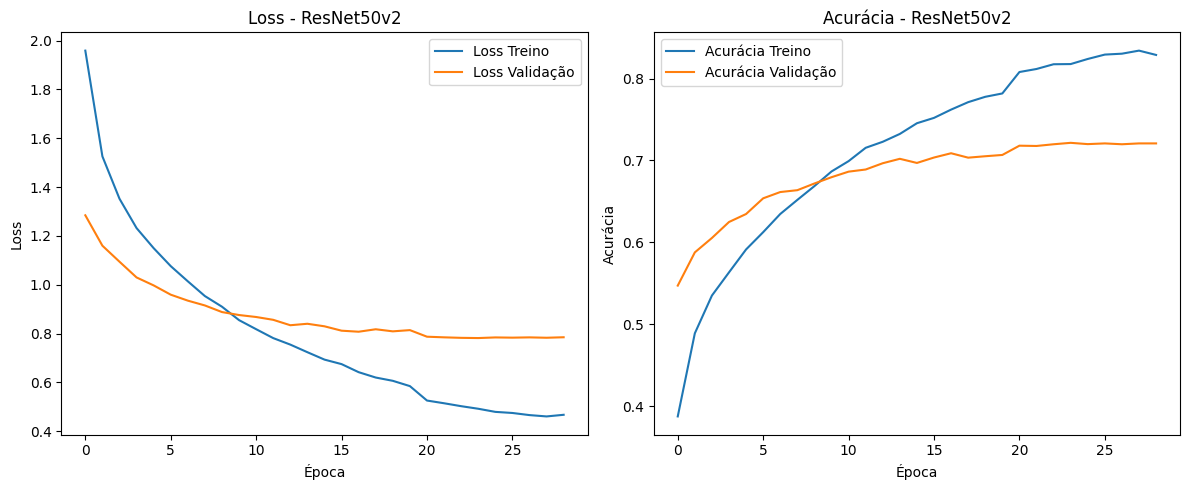

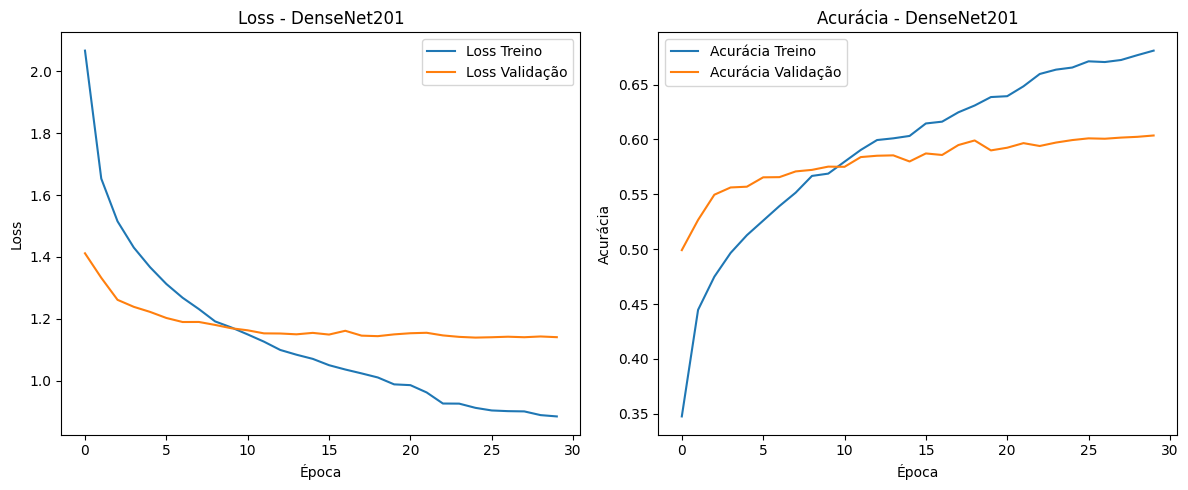

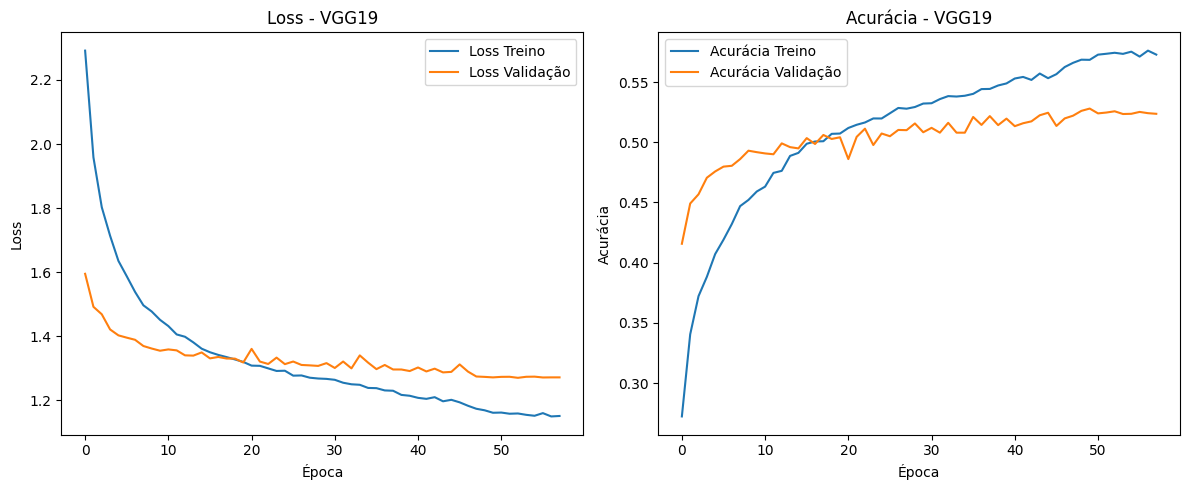

In [7]:
for model_name, history in histories.items():
    show_train_loss_accuracy(history, model_name)

In [8]:
#load models
from tensorflow.keras.models import load_model

resnet50v2 = load_model("ResNet50v2/best_ResNet50v2_model_basic.keras")
denseNet201 = load_model("DenseNet201/best_DenseNet201_model_basic.keras")
vgg19 = load_model("VGG19/best_VGG19_model_basic.keras")
models = {
    "ResNet50v2": resnet50v2,
    "DenseNet201": denseNet201,
    "VGG19": vgg19,
    
}


In [9]:
from tensorflow.keras.utils import to_categorical
y_preds = {}
# Normaliza
X_train_resized = X_train.astype("float32") / 255.0
X_test_resized = X_test.astype("float32") / 255.0

# One-hot
y_train_cat = to_categorical(y_train, num_classes=OUTPUT_CLASSES)
y_test_cat = to_categorical(y_test, num_classes=OUTPUT_CLASSES)
for model_name, model in models.items():
    y_preds[model_name] = get_preds(X_train_resized, model)

898/898 ━━━━━━━━━━━━━━━━━━━━ 384s 420ms/step
898/898 ━━━━━━━━━━━━━━━━━━━━ 705s 773ms/step
898/898 ━━━━━━━━━━━━━━━━━━━━ 1323s 1s/step


Métricas do modelo: ResNet50v2
Accuracy Score:   0.8907
Precision Score:  0.8967
Recall Score:     0.8412
F1 Score:         0.8601

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4056
           1       0.94      0.52      0.67       789
           2       0.88      0.85      0.86      3519
           3       0.93      0.95      0.94      6301
           4       0.93      0.92      0.93      3292
           5       0.87      0.92      0.90      5567
           6       0.85      0.89      0.87      5185

    accuracy                           0.89     28709
   macro avg       0.90      0.84      0.86     28709
weighted avg       0.89      0.89      0.89     28709


Acurácia por classe:
- angry: 84.86%
- disgust: 51.71%
- fear: 84.51%
- happy: 95.45%
- neutral: 91.80%
- sad: 91.68%
- surprise: 88.83%


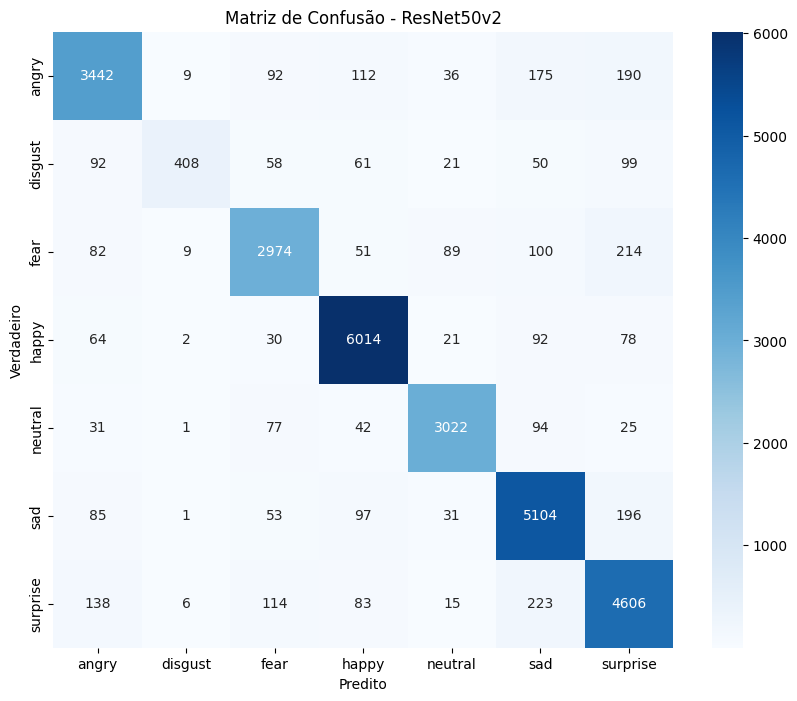

Métricas do modelo: DenseNet201
Accuracy Score:   0.7306
Precision Score:  0.7451
Recall Score:     0.6723
F1 Score:         0.6913

Classification Report:

              precision    recall  f1-score   support

           0       0.68      0.63      0.66      4056
           1       0.85      0.33      0.47       789
           2       0.70      0.61      0.65      3519
           3       0.79      0.87      0.82      6301
           4       0.81      0.80      0.81      3292
           5       0.72      0.75      0.73      5567
           6       0.67      0.72      0.69      5185

    accuracy                           0.73     28709
   macro avg       0.75      0.67      0.69     28709
weighted avg       0.73      0.73      0.73     28709


Acurácia por classe:
- angry: 63.44%
- disgust: 32.70%
- fear: 60.84%
- happy: 86.54%
- neutral: 79.95%
- sad: 75.07%
- surprise: 72.09%


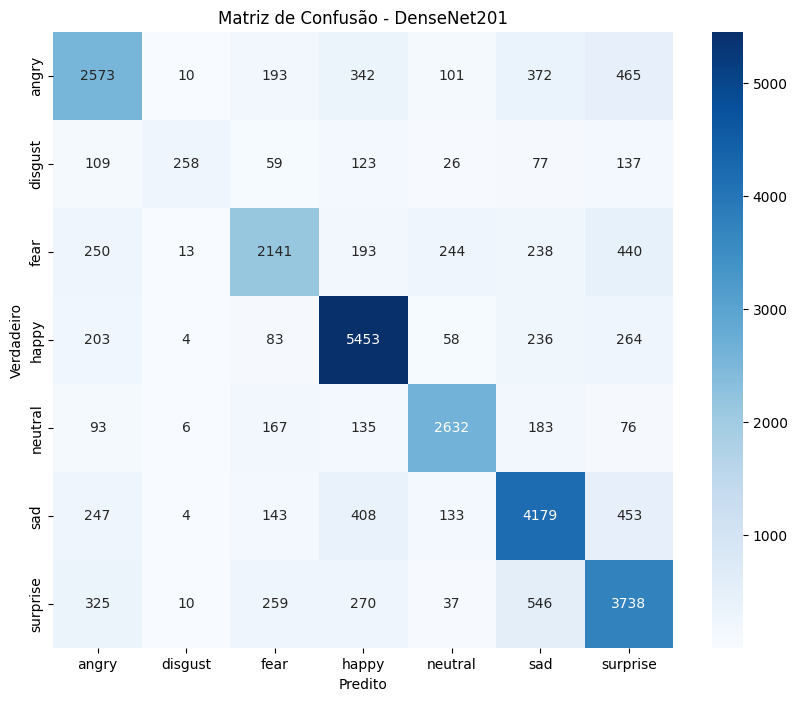

Métricas do modelo: VGG19
Accuracy Score:   0.6225
Precision Score:  0.6598
Recall Score:     0.5556
F1 Score:         0.569

Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.50      0.54      4056
           1       0.84      0.17      0.28       789
           2       0.67      0.41      0.51      3519
           3       0.65      0.79      0.72      6301
           4       0.73      0.76      0.74      3292
           5       0.61      0.63      0.62      5567
           6       0.54      0.64      0.58      5185

    accuracy                           0.62     28709
   macro avg       0.66      0.56      0.57     28709
weighted avg       0.63      0.62      0.61     28709


Acurácia por classe:
- angry: 49.70%
- disgust: 16.60%
- fear: 41.09%
- happy: 78.88%
- neutral: 76.03%
- sad: 62.55%
- surprise: 64.07%


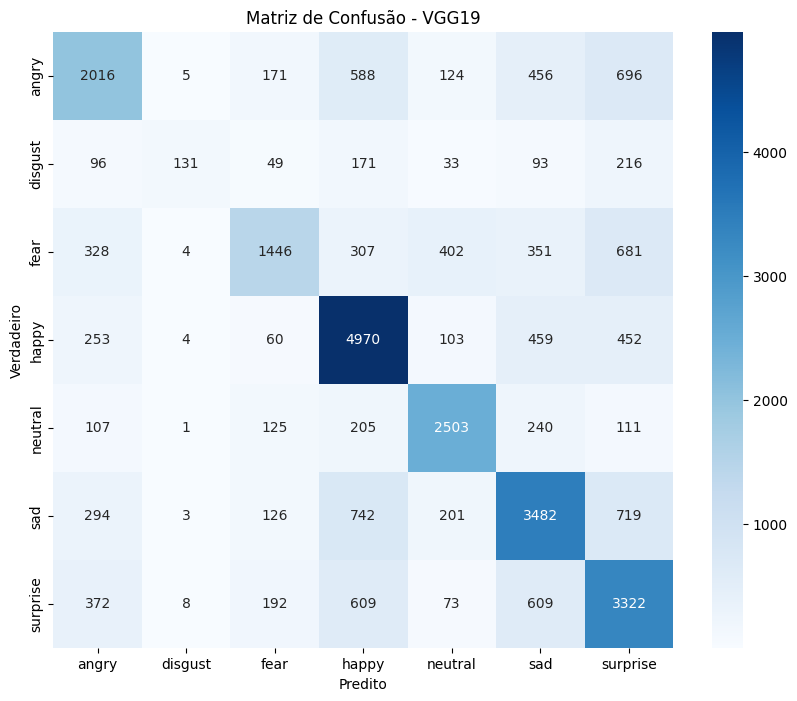

In [10]:
metrics = {}
for model_name, preds in y_preds.items():
    metrics[model_name] = show_metrics(y_train, preds, model_name, "confusion_matrix_completa_flatten", LABEL_MAP)

In [11]:
y_preds_teste = {}
for model_name, model in models.items():
    y_preds_teste[model_name] = get_preds(X_test_resized, model)

225/225 ━━━━━━━━━━━━━━━━━━━━ 94s 412ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 173s 759ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step


Métricas do modelo: ResNet50v2
Accuracy Score:   0.5364
Precision Score:  0.5168
Recall Score:     0.4981
F1 Score:         0.5038

Classification Report:

              precision    recall  f1-score   support

           0       0.42      0.43      0.43       958
           1       0.45      0.32      0.38       111
           2       0.41      0.31      0.36      1024
           3       0.77      0.68      0.72      1774
           4       0.68      0.69      0.68       831
           5       0.47      0.57      0.51      1233
           6       0.42      0.47      0.45      1247

    accuracy                           0.54      7178
   macro avg       0.52      0.50      0.50      7178
weighted avg       0.54      0.54      0.54      7178


Acurácia por classe:
- angry: 43.42%
- disgust: 32.43%
- fear: 31.45%
- happy: 68.26%
- neutral: 68.71%
- sad: 56.93%
- surprise: 47.47%


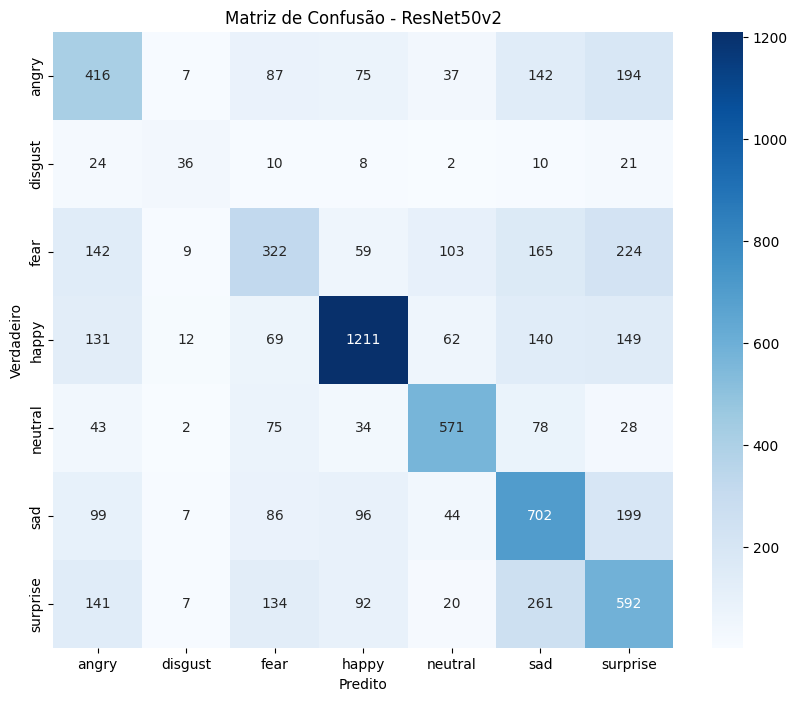

Métricas do modelo: DenseNet201
Accuracy Score:   0.5325
Precision Score:  0.5192
Recall Score:     0.4798
F1 Score:         0.4893

Classification Report:

              precision    recall  f1-score   support

           0       0.44      0.45      0.44       958
           1       0.51      0.23      0.31       111
           2       0.41      0.29      0.34      1024
           3       0.72      0.69      0.71      1774
           4       0.66      0.65      0.65       831
           5       0.47      0.57      0.51      1233
           6       0.43      0.48      0.45      1247

    accuracy                           0.53      7178
   macro avg       0.52      0.48      0.49      7178
weighted avg       0.53      0.53      0.53      7178


Acurácia por classe:
- angry: 44.89%
- disgust: 22.52%
- fear: 29.49%
- happy: 69.17%
- neutral: 65.22%
- sad: 56.85%
- surprise: 47.71%


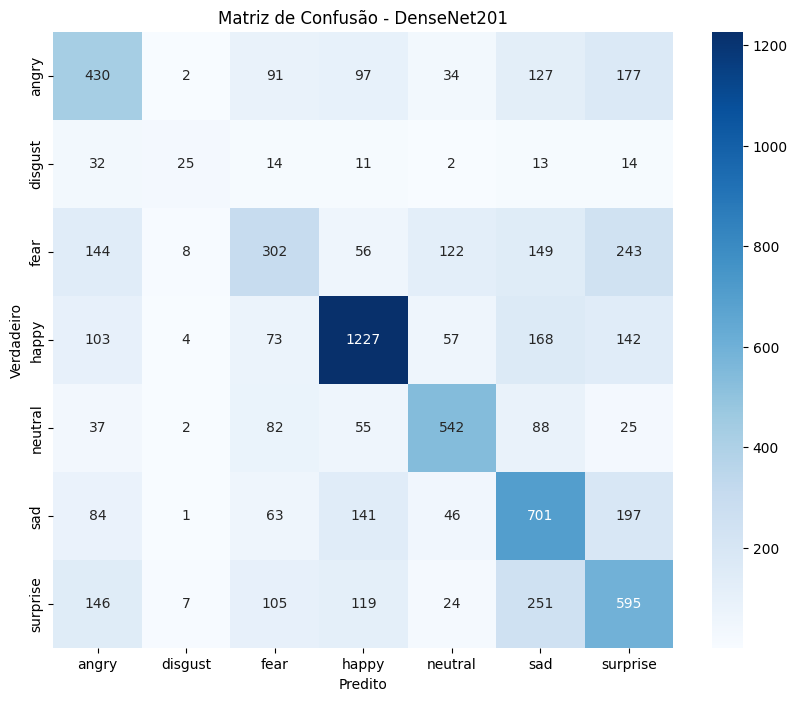

Métricas do modelo: VGG19
Accuracy Score:   0.4929
Precision Score:  0.487
Recall Score:     0.4367
F1 Score:         0.4435

Classification Report:

              precision    recall  f1-score   support

           0       0.40      0.38      0.39       958
           1       0.51      0.17      0.26       111
           2       0.42      0.21      0.28      1024
           3       0.64      0.68      0.66      1774
           4       0.64      0.66      0.65       831
           5       0.43      0.52      0.47      1233
           6       0.37      0.45      0.41      1247

    accuracy                           0.49      7178
   macro avg       0.49      0.44      0.44      7178
weighted avg       0.49      0.49      0.48      7178


Acurácia por classe:
- angry: 37.58%
- disgust: 17.12%
- fear: 21.29%
- happy: 67.70%
- neutral: 65.58%
- sad: 51.66%
- surprise: 44.75%


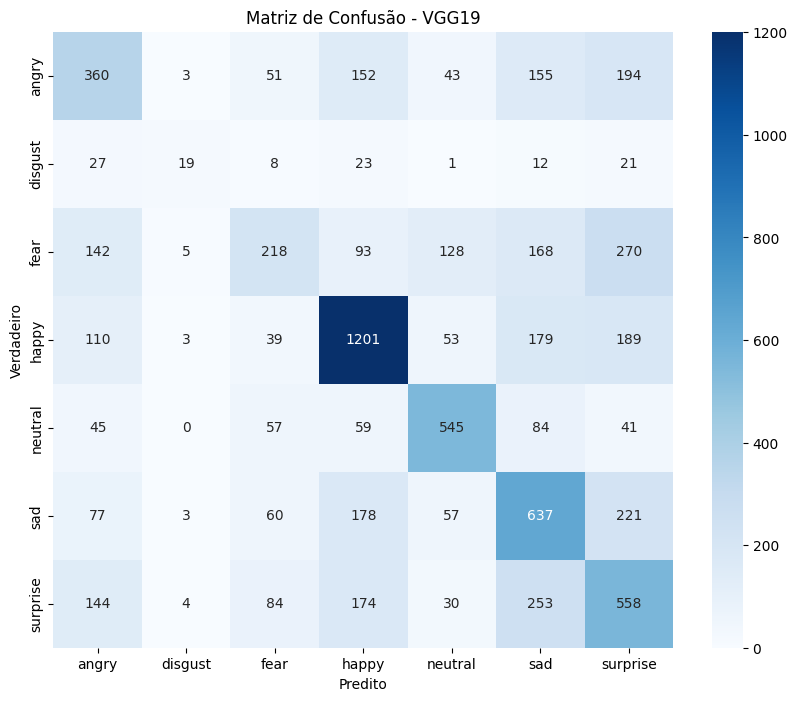

In [12]:
metrics_teste = {}
for model_name, preds in y_preds_teste.items():
    metrics_teste[model_name] = show_metrics(y_test, preds, model_name,"confusion_matrix_completa_flatten", LABEL_MAP, is_test=True)